<a href="https://colab.research.google.com/github/filmerxyz/JSTP-22_SkinDiseaseClassificationUsingMachineLearning/blob/master/CIFAR_10_DenseNet201.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**CIFAR-10**

# Import Libraries

In [0]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Dropout, Activation, Flatten, GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.imagenet_utils import preprocess_input
# from tensorflow.keras.applications.nasnet import decode_predictions
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import regularizers

from tensorflow.keras.datasets import cifar10

import numpy as np
import matplotlib.pyplot as plt

# Parameters

In [0]:
IMG_WIDTH = 32
IMG_HEIGHT = 32
NUM_CLASSES = 10
BATCH_SIZE = 32
EPOCHS = 50

# The data, split between train and test sets:

In [0]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# See shape

In [0]:
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


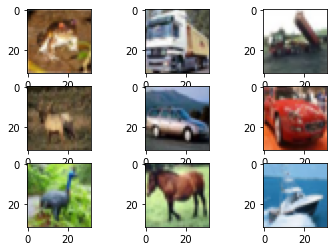

In [0]:
img_rows, img_cols , channels= 32,32,3
for i in range(0,9):
    plt.subplot(330 + 1 + i)
    plt.imshow(x_train[i])
plt.show()

# Augmentation

In [0]:
datagen = ImageDataGenerator(
    rotation_range=15,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.3
    )
datagen.fit(x_train)

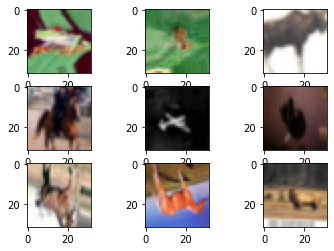

In [0]:
for X_batch, y_batch in datagen.flow(x_train, y_train, batch_size=9):
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i].astype(np.uint8))
    plt.show()
    break

# One how encoding

In [0]:
y_train = tf.keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test = tf.keras.utils.to_categorical(y_test, NUM_CLASSES)

# Normalize

In [0]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# Steps

In [0]:
train_steps_per_epoch = x_train.shape[0] // BATCH_SIZE
val_steps_per_epoch = x_test.shape[0] // BATCH_SIZE

# Model

In [0]:
base_model = tf.keras.applications.DenseNet201(include_top=False, weights='imagenet', input_shape=x_train.shape[1:])

In [0]:
len(base_model.layers)

707

In [0]:
# base_model.summary()

# Fine Tune

Freeze layer

In [0]:
# base_model.trainable = False

In [0]:
# for layer in base_model.layers[:350]:
#   layer.trainable = False

In [0]:
# base_model.summary()

In [0]:
average_pooling_layer = GlobalAveragePooling2D()(base_model.output)
dense1 = Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.01))(average_pooling_layer)
# dense2 = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(dense1)
dense3 = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(dense1)
dense4 = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(dense3)
dense5 = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))(dense4)
dropout1 = Dropout(0.5)(dense5)
prediction_layer = Dense(units=NUM_CLASSES, activation='softmax', name='prediction')(dropout1)
model = tf.keras.models.Model(inputs=base_model.input, outputs=prediction_layer)

In [0]:
model.compile(optimizer=Adam(lr=9e-5), loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
# model.summary()

# Callbacks

In [0]:
early_stop = EarlyStopping(monitor='val_loss',
                           min_delta=0,
                           patience=2,
                           verbose=0, 
                           mode='auto')

In [0]:
cb_list = [early_stop]

In [0]:
history = model.fit(x_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_data=(x_test, y_test),
          callbacks=cb_list,
          validation_split=0.2,
          shuffle=True)

Epoch 1/50
1250/1250 [==============================] - 115s 92ms/step - loss: 8.4524 - accuracy: 0.5512 - val_loss: 3.4114 - val_accuracy: 0.7719
Epoch 2/50
1250/1250 [==============================] - 109s 87ms/step - loss: 2.4621 - accuracy: 0.7615 - val_loss: 1.6397 - val_accuracy: 0.8148
Epoch 3/50
1250/1250 [==============================] - 109s 87ms/step - loss: 1.4295 - accuracy: 0.8237 - val_loss: 1.1945 - val_accuracy: 0.8198
Epoch 4/50
1250/1250 [==============================] - 108s 86ms/step - loss: 1.0270 - accuracy: 0.8674 - val_loss: 0.9793 - val_accuracy: 0.8430
Epoch 5/50
1250/1250 [==============================] - 108s 86ms/step - loss: 0.8095 - accuracy: 0.8961 - val_loss: 0.9155 - val_accuracy: 0.8412
Epoch 6/50
1250/1250 [==============================] - 108s 86ms/step - loss: 0.6648 - accuracy: 0.9155 - val_loss: 0.8139 - val_accuracy: 0.8511
Epoch 7/50
1250/1250 [==============================] - 108s 86ms/step - loss: 0.5540 - accuracy: 0.9323 - val_loss: 0

# Graph

**Accuracy**

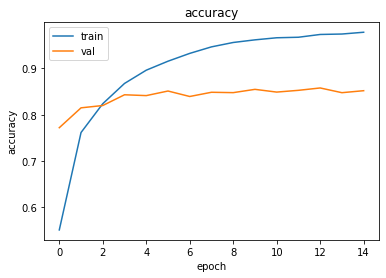

In [0]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('accuracy')
plt.show()

**Loss**

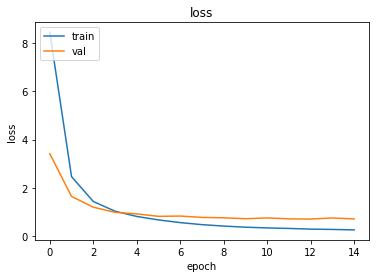

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('loss')
plt.show()

# Scores

In [0]:
scores = model.evaluate(x_test, y_test, verbose=1)

313/313 [==============================] - 8s 26ms/step - loss: 0.7078 - accuracy: 0.8496


In [0]:
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Test loss: 0.7078394293785095
Test accuracy: 0.8496000170707703
